In [1]:
#author: Jeremy McMahan
import numpy as np
from gurobipy import *
import matplotlib.pyplot as plt
from time import time
plt.rcParams["font.size"] = "20"

In [2]:
#Uniformly Random Games in [-1,1]
def get_random_game(n=5,m=5):
    A = np.random.uniform(-1,1,(n,m))
    B = np.random.uniform(-1,1,(n,m))
    return A, B

In [3]:
#Uniformly Random Markov Games in [-1,1]
def get_random_markov(H = 1, S = 1, n = 5, m = 5):
    P = np.ones((H,S,n,m,S))*1/S
    mu = np.zeros(S)
    mu[0] = 1
    Rv = np.random.uniform(-1,1,(H, S, n, m))
    Re = np.random.uniform(-1,1,(H, S, n, m))
    return Rv, Re, P, mu

In [4]:
#Block Diagonal Sample Game
def get_diag_game(r = 10, x = 10, y = 5):
    A = np.kron(np.eye(r),np.array([[x, 2*x],[0,3*x]]))
    B = np.kron(np.eye(r),np.array([[y, 0],[y,0]]))
    return A, B

In [5]:
#Block Diagonal Sample Game2
def get_diag_game2(r = 10, x = 10, y = 10):
    A = np.kron(np.eye(r),np.array([[x, x],[x,x],[-1,-1]]))
    B = np.kron(np.eye(r),np.array([[2*y, -1],[y,-1],[-1,0]]))
    return A, B

In [6]:
#Block Diagonal Sample Markov Game2
def get_diag_markov2(H = 1, S = 1, r = 10, x = 10, y = 10):
    Rv = np.zeros((H,S,3*r,2*r))
    Re = np.zeros((H,S,3*r,2*r))
    P = np.ones((H,S,3*r,2*r,S))*1/S
    mu = np.zeros(S)
    mu[0] = 1
    Rv[:,:] = np.kron(np.eye(r),np.array([[x, x],[x,x],[-1,-1]]))
    Re[:,:] = np.kron(np.eye(r),np.array([[2*y, -1],[y,-1],[-1,0]]))
    return Rv, Re, P, mu

In [7]:
#Block Diagonal Sample Markov Game
def get_diag_markov(H = 1, S = 1, r = 10, x = 10, y = 5):
    Rv = np.zeros((H,S,2*r,2*r))
    Re = np.zeros((H,S,2*r,2*r))
    P = np.ones((H,S,2*r,2*r,S))*1/S
    mu = np.zeros(S)
    mu[0] = 1
    Rv[:,:] = np.kron(np.eye(r),np.array([[x, 2*x],[0,3*x]]))
    Re[:,:] = np.kron(np.eye(r),np.array([[y, 0],[y,0]]))
    return Rv, Re, P, mu

In [8]:
#Victim LP
def victim_LP(A):
    n,m = A.shape
    victim = Model()
    victim.setParam('OutputFlag', False)
    x = victim.addMVar(n, 0, 1, name = 'x')
    z = victim.addVar(lb = -GRB.INFINITY, name = 'z')
    victim.addConstrs((x @ A[:,j] >= z for j in range(m)), name='matrix')
    victim.addConstr(x @ np.ones(n) == 1, name='prob')
    victim.setObjective(z, GRB.MAXIMIZE)
    victim.optimize()
    return x.X, z.X

In [9]:
#Victim Algorithm
def victim_alg(R,P,mu):
    H, S, n, m = R.shape
    pi = np.zeros((H,S,n))
    V = np.zeros((H+1,S))
    Q = np.zeros((H+1,S,n,m))
    for h in range(H-1, -1, -1):
        for s in range(S):
            Q[h,s] = R[h,s] + (P[h,s] @ V[h+1])
            pi[h,s], V[h,s] = victim_LP(Q[h,s])
    return pi, V[0] @ mu

In [10]:
#exploiter LP
def exploiter_LP(A,B):
    n,m = A.shape
    _, z = victim_LP(A)
    exploiter = Model()
    exploiter.setParam('OutputFlag', False)
    y = exploiter.addMVar(m, 0, 1, name = 'y')
    w = exploiter.addMVar(m, name = 'w')
    a = exploiter.addVar(lb = -GRB.INFINITY, name = 'a')
    exploiter.addConstrs((a + B[i,:] @ y - A[i,:] @ w >= 0 for i in range(n)), name='matrix')
    exploiter.addConstr(np.ones(m) @ y == 1, name='prob')
    exploiter.setObjective(z * (w @ np.ones(m)) - a, GRB.MAXIMIZE)
    exploiter.optimize()
    return y.X, z * (w.X @ np.ones(m)) - a.X, z

In [11]:
#Exploiter Algorithm
def exploiter_alg(Rv,Re,P,mu):
    H,S, n, m = Rv.shape
    nu = np.zeros((H,S,m))
    Vv = np.zeros((H+1,S))
    Ve = np.zeros((H+1,S))
    Qv = np.zeros((H+1,S,n,m))
    Qe = np.zeros((H+1,S,n,m))
    for h in range(H-1, -1, -1):
        for s in range(S):
            Qv[h,s] = Rv[h,s] + (P[h,s] @ Vv[h+1])
            Qe[h,s] = Re[h,s] + (P[h,s] @ Ve[h+1])
            nu[h,s], Ve[h,s], Vv[h,s] = exploiter_LP(Qv[h,s], Qe[h,s])
    return nu, Ve[0] @ mu

In [13]:
#Get value of the game under pi, nu pair
def get_val(R, P, mu, pi, nu):
    H,S,n,m = R.shape
    V = np.zeros((H+1,S))
    for h in range(H-1, -1, -1):
        for s in range(S):
            V[h,s] = pi[h,s] @ (R[h,s] + (P[h,s] @ V[h+1])) @ nu[h,s]
    return V[0] @ mu

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-14


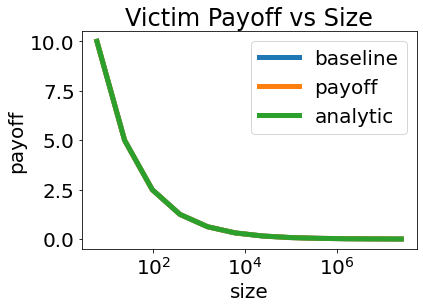

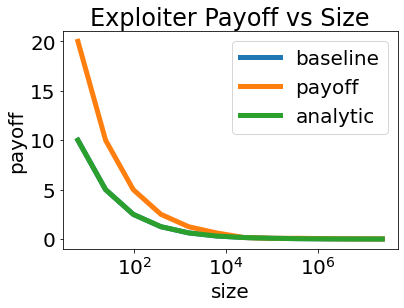

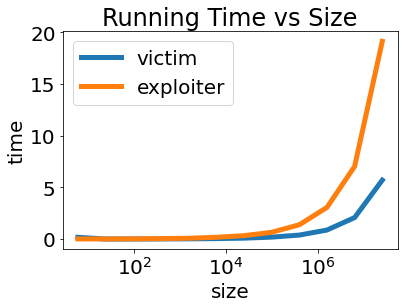

In [14]:
#experiment 1
k = 12
rs = [2**i for i in range(k)]
p_v = []
p_e = []
pay_v = []
pay_e = []
time_v = []
time_e = []
size = []

for r in rs:
    A, B = get_diag_game2(r)
    size.append(A.size)
    time_startv = time()
    x, p_vr = victim_LP(A)
    time_endv = time()
    time_starte = time()
    y, p_er, _ = exploiter_LP(A,B)
    time_ende = time()
    p_v.append(p_vr)
    p_e.append(p_er)
    pay_v.append(x @ A @ y)
    pay_e.append(x @ B @ y)
    time_v.append(time_endv - time_startv)
    time_e.append(time_ende - time_starte)

#Victim payoffs
plt.plot(size, p_v, label='baseline', linewidth = 5)
plt.plot(size, pay_v, label='payoff', linewidth = 5)
plt.plot(size, [10/r for r in rs], label='analytic', linewidth = 5)
plt.xlabel('size')
plt.ylabel('payoff')
plt.title('Victim Payoff vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('victim_payoff1.png', dpi=300, bbox_inches = "tight")
plt.show()

#Exploiter payoffs
plt.plot(size, p_e, label='baseline', linewidth = 5)
plt.plot(size, pay_e, label='payoff', linewidth = 5)
plt.plot(size, [10/r for r in rs], label='analytic', linewidth = 5)
plt.xlabel('size')
plt.ylabel('payoff')
plt.title('Exploiter Payoff vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('exploiter_payoff1.png', dpi=300, bbox_inches = "tight")
plt.show()

#Running time analysis
plt.plot(size, time_v, label='victim', linewidth = 5)
plt.plot(size, time_e, label='exploiter', linewidth = 5)
plt.xlabel('size')
plt.ylabel('time')
plt.title('Running Time vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('time1.png', dpi=300, bbox_inches = "tight")
plt.show()

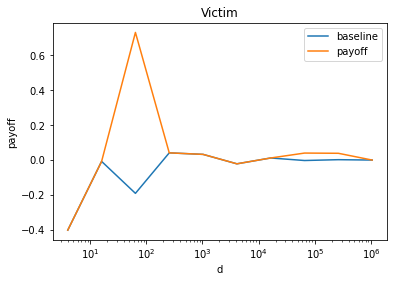

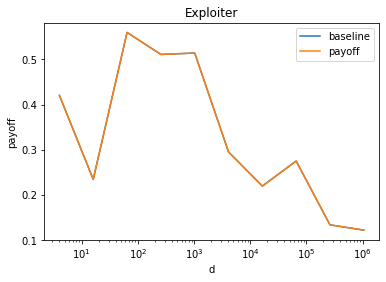

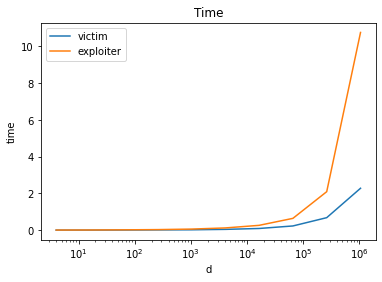

In [159]:
#experiment 2
k = 11
ds = [2**i for i in range(1,k)]
p_v = []
p_e = []
pay_v = []
pay_e = []
time_v = []
time_e = []
size = []

for d in ds:
    A, B = get_random_game(d,d)
    size.append(A.size)
    time_startv = time()
    x, p_vd = victim_LP(A)
    time_endv = time()
    time_starte = time()
    y, p_ed, _ = exploiter_LP(A,B)
    time_ende = time()
    p_v.append(p_vd)
    p_e.append(p_ed)
    pay_v.append(x @ A @ y)
    pay_e.append(x @ B @ y)
    time_v.append(time_endv - time_startv)
    time_e.append(time_ende - time_starte)

#Victim payoffs
plt.plot(size, p_v, label='baseline', linewidth = 5)
plt.plot(size, pay_v, label='payoff', linewidth = 5)
plt.xlabel('d')
plt.ylabel('payoff')
plt.title('Victim')
plt.legend()
plt.xscale('log')
plt.savefig('victim_payoff2.png',dpi=300)
plt.show()

#Exploiter payoffs
plt.plot(size, p_e, label='baseline', linewidth = 5)
plt.plot(size, pay_e, label='payoff', linewidth = 5)
plt.xlabel('d')
plt.ylabel('payoff')
plt.title('Exploiter')
plt.legend()
plt.xscale('log')
plt.savefig('exploiter_payoff2.png',dpi=300)
plt.show()

#Running time analysis
plt.plot(size, time_v, label='victim', linewidth = 5)
plt.plot(size, time_e, label='exploiter', linewidth = 5)
plt.xlabel('d')
plt.ylabel('time')
plt.title('Time')
plt.legend()
plt.xscale('log')
plt.savefig('time2.png',dpi=300)
plt.show()

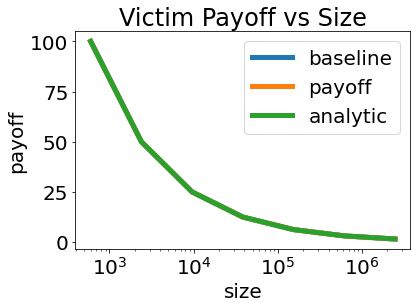

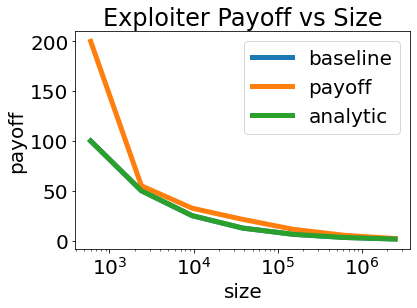

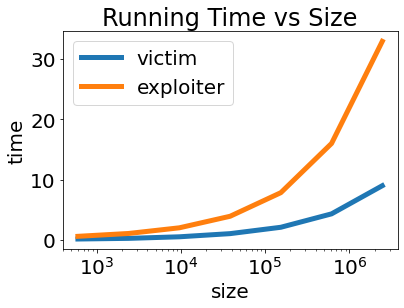

In [194]:
#experiment 3
k = 7
H = 10
S = 10
rs = [2**i for i in range(k)]
p_v = []
p_e = []
pay_v = []
pay_e = []
time_v = []
time_e = []
size = []

for r in rs:
    Rv, Re, P, mu = get_diag_markov2(H,S,r)
    size.append(Rv.size)
    time_startv = time()
    pi, p_vr = victim_alg(Rv,P,mu)
    time_endv = time()
    time_starte = time()
    nu, p_er = exploiter_alg(Rv,Re,P,mu)
    time_ende = time()
    p_v.append(p_vr)
    p_e.append(p_er)
    pay_v.append(get_val(Rv, P , mu, pi, nu))
    pay_e.append(get_val(Re, P , mu, pi, nu))
    time_v.append(time_endv - time_startv)
    time_e.append(time_ende - time_starte)

#Victim payoffs
plt.plot(size, p_v, label='baseline', linewidth = 5)
plt.plot(size, pay_v, label='payoff', linewidth = 5)
plt.plot(size, [H*10/r for r in rs], label='analytic', linewidth = 5)
plt.xlabel('size')
plt.ylabel('payoff')
plt.title('Victim Payoff vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('victim_payoff3.png',dpi=300, bbox_inches = "tight")
plt.show()

#Exploiter payoffs
plt.plot(size, p_e, label='baseline', linewidth = 5)
plt.plot(size, pay_e, label='payoff', linewidth = 5)
plt.plot(size, [H*10/r for r in rs], label='analytic', linewidth = 5)
plt.xlabel('size')
plt.ylabel('payoff')
plt.title('Exploiter Payoff vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('exploiter_payoff3.png',dpi=300, bbox_inches = "tight")
plt.show()

#Running time analysis
plt.plot(size, time_v, label='victim', linewidth = 5)
plt.plot(size, time_e, label='exploiter', linewidth = 5)
plt.xlabel('size')
plt.ylabel('time')
plt.title('Running Time vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('time3.png',dpi=300, bbox_inches = "tight")
plt.show()

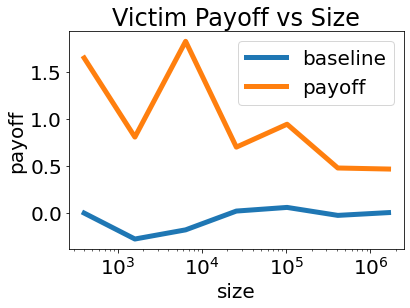

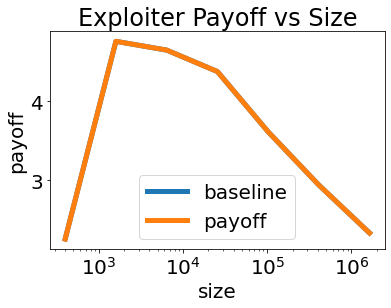

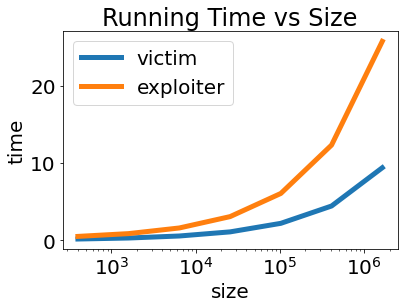

In [195]:
#experiment 4
k = 8
ds = [2**i for i in range(1,k)]
H = 10
S = 10
p_v = []
p_e = []
pay_v = []
pay_e = []
time_v = []
time_e = []
size = []

for d in ds:
    Rv, Re, P, mu = get_random_markov(H,S,d,d)
    size.append(Rv.size)
    time_startv = time()
    pi, p_vd = victim_alg(Rv,P,mu)
    time_endv = time()
    time_starte = time()
    nu, p_ed = exploiter_alg(Rv,Re,P,mu)
    time_ende = time()
    p_v.append(p_vd)
    p_e.append(p_ed)
    pay_v.append(get_val(Rv, P , mu, pi, nu))
    pay_e.append(get_val(Re, P , mu, pi, nu))
    time_v.append(time_endv - time_startv)
    time_e.append(time_ende - time_starte)

#Victim payoffs
plt.plot(size, p_v, label='baseline', linewidth = 5)
plt.plot(size, pay_v, label='payoff', linewidth = 5)
plt.xlabel('size')
plt.ylabel('payoff')
plt.title('Victim Payoff vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('victim_payoff4.png',dpi=300, bbox_inches = "tight")
plt.show()

#Exploiter payoffs
plt.plot(size, p_e, label='baseline', linewidth = 5)
plt.plot(size, pay_e, label='payoff', linewidth = 5)
plt.xlabel('size')
plt.ylabel('payoff')
plt.title('Exploiter Payoff vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('exploiter_payoff4.png',dpi=300, bbox_inches = "tight")
plt.show()

#Running time analysis
plt.plot(size, time_v, label='victim', linewidth = 5)
plt.plot(size, time_e, label='exploiter', linewidth = 5)
plt.xlabel('size')
plt.ylabel('time')
plt.title('Running Time vs Size')
plt.legend()
plt.xscale('log')
plt.savefig('time4.png',dpi=300, bbox_inches = "tight")
plt.show()